# Load torch device

In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW

# --- this part is required for mac --- #
import sys, os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# comment out if youre on windows and remove 'src.' prefixes from imports #

from src.Datasets.batching import BatchManager

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Choose NCars or NCaltech-101 Dataset

In [2]:
from Datasets.ncaltech101 import NCaltech
from Datasets.ncars import NCars

# options: 'ncars' or 'ncaltech'
dataset = 'ncars'  
#dataset = 'ncaltech'

if dataset == 'ncars':
    num_classes = len(NCars.get_info().classes)
    image_size: tuple[int, int] = NCars.get_info().image_size  # (height=240, width=180)
if dataset == 'ncaltech':
    num_classes = len(NCaltech.get_info().classes)
    image_size: tuple[int, int] = NCaltech.get_info().image_size  # (height=240, width=180)

# Model Initialization

In [3]:
from src.Models.CleanEvGNN.recognition import RecognitionModel as EvGNN
from torch_geometric.data import Data as PyGData
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape: tuple[int, int, int] = (*image_size, 3)

# Vertausche Dimensionen: pos ist [x, y] = [width, height], also übergeben wir (width, height)
img_shape_for_model = (image_size[1], image_size[0])  # (180, 240) statt (240, 180)

evgnn = EvGNN(
    network="graph_res",
    dataset=dataset,
    num_classes = num_classes,
    img_shape=img_shape_for_model,  # (width=180, height=240)
    dim=3,
    conv_type="ori_aegnn",
    distill=False,        # <– no KD, just normal training
).to(device)


def transform_graph(graph: PyGData) -> PyGData:
    return evgnn.data_transform(
        graph, n_samples=25000, sampling=True,
        beta=0.5e-5, radius=5.0,
        max_neighbors=32
    ).to(device)

/Users/mielgeraats/miniconda3/envs/GNNBenchmark/lib/python3.11/site-packages/lightning_fabric/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


# Dataset Initialization and processing (from the parsed dataset from the aegnn issues thread)

In [4]:
#Instantiating the ncaltech dataset
if dataset == 'ncaltech':
    dataset_obj = NCaltech(
        #root=r"C:\Users\hanne\Documents\Hannes\Uni\Maastricht\Project\Datasets",
        root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/N-Caltech101',
        transform=transform_graph
    )
if dataset == 'ncars':
    dataset_obj = NCars(
        #root=r"C:\Users\hanne\Documents\Hannes\Uni\Maastricht\Project\Datasets",
        root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/Prophesee_Dataset_n_cars',
        transform=transform_graph
)

# Processing the training part of the dataset
dataset_obj.process(modes = ["training"])

Display example events data point

In [5]:
training_set = BatchManager(
    dataset=dataset_obj,
    batch_size=8,
    mode="training"
)

In [6]:
optimizer = Adam(evgnn.parameters(), lr=5e-4, weight_decay=6e-7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, cooldown=10)
loss_fn = CrossEntropyLoss()

classes = dataset_obj.get_info().classes

cls_to_idx = dict(zip(classes, range(len(classes))))

In [7]:
def label_to_index(lbl):
    if isinstance(lbl,str): # for n-caltech labels (strings)
        return cls_to_idx[lbl]
    if isinstance(lbl, torch.Tensor): # for ncars labels (tensors)
        return int(lbl.item())  

In [9]:
evgnn.train()
losses = []

for i in range(500):
    optimizer.zero_grad() 

    examples = next(training_set)
    reference = torch.tensor([label_to_index(lbl) for lbl in examples.label], dtype=torch.long).to(device)
    out = evgnn(examples)
    loss = loss_fn(out, reference)
    loss.backward()

    # Gradient Clipping für Stabilität
    torch.nn.utils.clip_grad_norm_(evgnn.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step(loss.item())

    #current_lr = scheduler.get_last_lr()[0]
    print(f"Iteration {i:3d} | Loss: {loss.item():.4f} | LR: temp")
    losses.append(loss.item())
torch.save(evgnn.state_dict(), f"evgnn_{dataset}_test.pth")
# i removed the time window in the data_transform function to make it work with ncaltech, mybe that could be a problem

RuntimeError: index 132 is out of bounds for dimension 0 with size 128

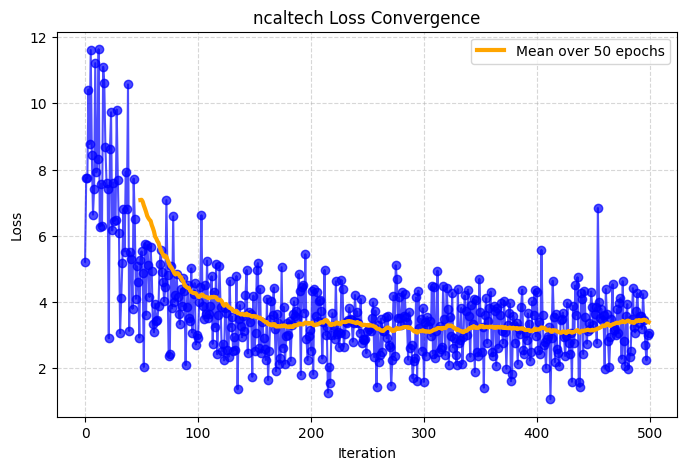

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_convergence(loss_list, window=50, title=f"{dataset} Loss Convergence", xlabel="Iteration", ylabel="Loss"):
    """
    Plots the loss over iterations to visualize convergence.

    Parameters:
    - loss_list: List or array of loss values over iterations
    - title: Plot title
    - xlabel: X-axis label
    - ylabel: Y-axis label
    """
    plt.figure(figsize=(8,5))
    plt.plot(loss_list, marker='o', linestyle='-', color='blue', alpha=0.7)
    moving_mean = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_mean, color='orange', linewidth=3, label=f'Mean over {window} epochs')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

plot_loss_convergence(losses)

In [ ]:
evgnn.eval()
predictions_made = 0
correct = 0
with torch.no_grad():
    for i in range(50):
        examples = next(training_set)
        reference = torch.tensor([label_to_index(lbl) for lbl in examples.label], dtype=torch.long).to(device)
        out = evgnn(examples)
        prediction = out.argmax(dim = -1)
        is_correct = prediction - reference
        is_correct = is_correct[is_correct == 0]
        correct += is_correct.shape[0]
        predictions_made += prediction.shape[0]

        print(f"Accuracy: {correct / predictions_made}")

print(f"Accuracy: {correct / predictions_made}")

Accuracy: 0.125
Accuracy: 0.1875
Accuracy: 0.125
Accuracy: 0.125
Accuracy: 0.225
Accuracy: 0.25
Accuracy: 0.25
Accuracy: 0.296875
Accuracy: 0.2916666666666667
Accuracy: 0.3
Accuracy: 0.29545454545454547
Accuracy: 0.2708333333333333
Accuracy: 0.2692307692307692
Accuracy: 0.25892857142857145
Accuracy: 0.26666666666666666
Accuracy: 0.2578125
Accuracy: 0.25735294117647056
Accuracy: 0.2638888888888889
Accuracy: 0.2631578947368421
Accuracy: 0.2625
Accuracy: 0.26785714285714285
Accuracy: 0.26704545454545453
Accuracy: 0.2717391304347826
Accuracy: 0.265625
Accuracy: 0.28
Accuracy: 0.27884615384615385
Accuracy: 0.28703703703703703
Accuracy: 0.29017857142857145
Accuracy: 0.28879310344827586
Accuracy: 0.3
Accuracy: 0.3024193548387097
Accuracy: 0.29296875
Accuracy: 0.29545454545454547
Accuracy: 0.29044117647058826
Accuracy: 0.2892857142857143
Accuracy: 0.2881944444444444
Accuracy: 0.2939189189189189
Accuracy: 0.3026315789473684
Accuracy: 0.30448717948717946
Accuracy: 0.30625
Accuracy: 0.31402439024